In [1]:
# imports
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']

from copy import deepcopy

from astropy import constants as c
from astropy import units as u

from plasmapy.formulary import mass_density 
from plasmapy.formulary import collision_frequency
from plasmapy.particles import reduced_mass

%load_ext watermark

In [2]:
%watermark --python --packages astropy,plasmapy,numpy,pandas,matplotlib

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 7.22.0

astropy   : 5.1
plasmapy  : 0.7.0
numpy     : 1.22.4
pandas    : 1.4.2
matplotlib: 3.5.2



# Properties of a stellar atmosphere

In this notebook we are going to examine some of the physical properties of a stellar atmosphere. We will use as our base the series of models known as FAL-93 ([Fontenla, Avert & Loeser, 1993](https://ui.adsabs.harvard.edu/abs/1993ApJ...406..319F/abstract)). These models are often used a proxy for the conditions on the Sun. However, as Rob Rutten likes to make clear: 

- *these are educational solar-analog “Avrett stars”. These computationally existing stars extend infinitely
plane-parallel (1D) without any inhomogeneities or any magnetism or any sort of waves or any type of reconnection – no granules, spicules, floccules, let be filaments, flares, CMEs, and whatever else that makes our kind Sun non-plane-parallel interesting. .... The solar atmosphere is not layered but
dynamically structured.* (Quote from [Rutten 2021](https://ui.adsabs.harvard.edu/abs/2021arXiv210302369R/abstract)).

With that made clear, let's look at a Sun.

In [79]:
# read in files
file_name = '/Users/richardmorton/analysis/FAL_models/fal_c.csv'
df = pd.read_csv(file_name, skiprows=[1])

In [80]:
# show columns
#df = df.drop(range(5))
df

,Unnamed: 0,Depth,Temp.,Electron,Proton,H(1),H(2),He(1),He(2),He II,He III
0,1,2220.0,103000.0,6.560000e+09,5.480000e+09,1.110000e+05,3.700000e-02,4.320000e+02,0.598,2.010000e+07,5.280000e+08
1,2,2220.0,98800.0,6.810000e+09,5.700000e+09,1.790000e+05,5.900000e-02,1.200000e+03,1.540,4.410000e+07,5.260000e+08
2,3,2220.0,94800.0,7.070000e+09,5.940000e+09,2.460000e+05,8.000000e-02,2.860000e+03,3.390,7.280000e+07,5.220000e+08
3,4,2220.0,90800.0,7.360000e+09,6.210000e+09,3.440000e+05,1.110000e-01,6.720000e+03,7.250,1.050000e+08,5.170000e+08
4,5,2210.0,83900.0,7.910000e+09,6.730000e+09,7.000000e+05,2.200000e-01,2.640000e+04,24.400,1.770000e+08,4.980000e+08
...,...,...,...,...,...,...,...,...,...,...,...
65,66,-20.0,6980.0,1.730000e+14,1.530000e+14,1.240000e+17,2.150000e+10,1.250000e+16,184.000,6.850000e+05,2.820000e-27
66,67,-40.0,7590.0,4.480000e+14,4.250000e+14,1.280000e+17,8.630000e+10,1.280000e+16,2660.000,8.370000e+06,2.180000e-23
67,68,-60.0,8220.0,1.050000e+15,1.020000e+15,1.300000e+17,2.900000e+11,1.310000e+16,27700.000,7.390000e+07,5.490000e-20
68,69,-80.0,8860.0,2.210000e+15,2.180000e+15,1.300000e+17,8.230000e+11,1.320000e+16,212000.000,4.890000e+08,4.960000e-17


## Number and mass density

From this data we will first calculate the total number densities of Hydrogen and Helium, and the total mass density, then show the density and temperature.

In [81]:
df['n_H'] = df['Proton']+df['H(1)']+df['H(2)']
df['n_He'] = df['He(1)']+df['He(2)']+df['He II']+df["He III"]

# rho in kg/m^3
df['rho'] = (mass_density(df['n_H'].values * u.cm**-3, 'H') \
            + mass_density(df['n_He'].values * u.cm**-3, 'He')).value

## Coronal extension

To extend this model to the corona, we follow Soler et al. (2017). First, the temperature is defined by a parabolic profile, determined to match the value of T at the upper chromosphere/transition region, with a coronal temperature, in this case $T_{cor}=10^6$, i.e. $T=(a+z/b)^{1/2}$

The density is then determined by assuming a gravitational stratified atmosphere, i.e. $\nabla p=\rho \vec{g}$. This leads to the ODE:

$$
\frac{d\rho}{dz}+\frac{\rho}{T}\left(\frac{dT}{dz}+\frac{g\mu}{R}\right)=0
$$

$$
\frac{d T}{dz}= \frac{(a+z/b)^{-1/2}}{2b}
$$

This has an analytic solution but we solve with Euler's method.

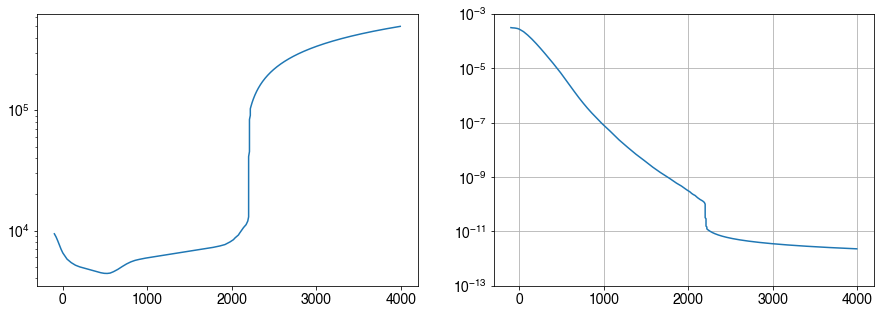

In [83]:
# Add corona

# Initial conditions
T_cor = 0.5e6 # K
z_cor = 4000 # km

z_step = 5 # step size

# solar constants
g_sun = 274*u.m*u.s**-2 # solar gravity
g_sun = g_sun.to(u.km*u.s**-2)
R = 8.3e3*u.m**2*u.s**-2*u.K**-1 # gas constant
R = R.to(u.km**2*u.s**-2*u.K**-1)
mu = 0.6 # mean atomic weight

# parabolic profile for T
b = (z_cor-df['Depth'][0])/(T_cor**2-df['Temp.'][0]**2)
a = df['Temp.'][0]**2-1/b*df['Depth'][0]

depth_cor = np.arange(df['Depth'][0], z_cor, z_step) # km
coronal_T_prof = np.sqrt(a+1/b*depth_cor)
test_profile = np.concatenate((coronal_T_prof[::-1],df["Temp."].values))
test_depth = np.concatenate((depth_cor[::-1], df["Depth"].values))



plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(test_depth, test_profile)
plt.yscale('log')

# density from gravitational stratifiction
#rho_cor = u.Quantity(np.zeros(len(depth_cor)), u.kg/u.m**3)
rho_cor = np.zeros(len(depth_cor))
for i, z_c in enumerate(depth_cor.tolist()):
    if i == 0:
        rho_n = df['rho'][0]
    else:
        rho_n = rho_cor[i-1]
    f = (a+1/b*z_c)**-0.5/2/b+(g_sun*mu/R).value
    #print((rho_n-z_step*rho_n*f/coronal_T_prof[i]))
    rho_cor[i]=(rho_n-z_step*rho_n*f/coronal_T_prof[i])


test_rho_profile = np.concatenate((rho_cor[::-1], 
                                   df["rho"].values))
plt.subplot(122)
plt.plot(test_depth, test_rho_profile)
plt.yscale('log')
plt.ylim(1e-13,1e-3)
plt.grid()

d = {'Temp.': coronal_T_prof[::-1],
     'Depth': depth_cor[::-1],
      'rho': rho_cor[::-1]}
df2 = pd.DataFrame(d)

# silly work around for Quantities
df2['rho']=rho_cor[::-1]
df = pd.concat([df2, df], ignore_index=True) #.fillna(0)


<Figure size 1224x360 with 0 Axes>

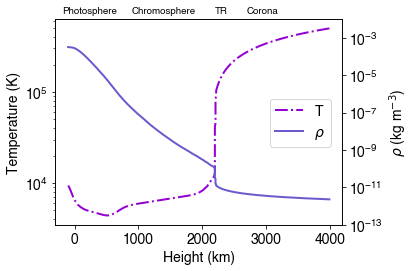

In [85]:
plt.figure(figsize=(17,5))
fig, ax1 =plt.subplots()

ax1.plot(df['Depth'], df['Temp.'], label='T', color='darkviolet', lw=2, linestyle='-.')
ax1.set_yscale('log')
ax1.set_xlabel('Height (km)')
ax1.set_ylabel('Temperature (K)')
#ax1.grid(axis='y')

ax2 = ax1.twinx()

ax2.plot(df['Depth'], df['rho'], label=r'$\rho$', color='slateblue', lw=2)
ax2.set_yscale('log')
ax2.set_ylabel(r'$\rho$ (kg m$^{-3}$)')
ax2.set_ylim(1e-13,1e-2)

ax2.text(-200, 2e-2, 'Photosphere', fontsize='x-small')
ax2.text(900, 2e-2, 'Chromosphere', fontsize='x-small')
ax2.text(2200, 2e-2, 'TR', fontsize='x-small')
ax2.text(2700, 2e-2, 'Corona', fontsize='x-small')

fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(0.8,0.65));
plt.savefig('T_rho_atmosphere.png', dpi=300)

## Fractions of species
Now we will calculate the fractions of each species in the atmosphere,as
$$
\xi_\beta = \frac{\rho_{\beta}}{\rho}
$$
where $\rho_\beta =m_\beta n_\beta$ is the mass density of species $\beta =$ e, p, H, He I, or He II.

In [86]:
# only do following calculation for lower solar atmosphere
df_lsa = deepcopy(df.loc[356:])

In [87]:
rho = df_lsa['rho'] * (u.kg * u.m**-3)

df_lsa['xi_H_n'] = mass_density((df_lsa['H(1)']+df_lsa['H(2)']).values * u.cm**-3, 'H') /rho
df_lsa['xi_H_i'] = mass_density(df_lsa['Proton'].values * u.cm**-3, 'p') / rho
df_lsa['xi_He_n'] = mass_density((df_lsa['He(1)']+df_lsa['He(2)']).values * u.cm**-3, 'He') /rho
df_lsa['xi_He_i'] = mass_density((df_lsa['He II']+df_lsa["He III"]).values * u.cm**-3, 'He') /rho
df_lsa['xi_He_II'] = mass_density((df_lsa['He II']).values * u.cm**-3, 'He') /rho


# all ions and neutrals
df_lsa['xi_i'] = df_lsa['xi_H_i']+df_lsa['xi_He_i']
df_lsa['xi_n'] = df_lsa['xi_H_n']+df_lsa['xi_He_n']

First we'll plot the fractions of individual species.

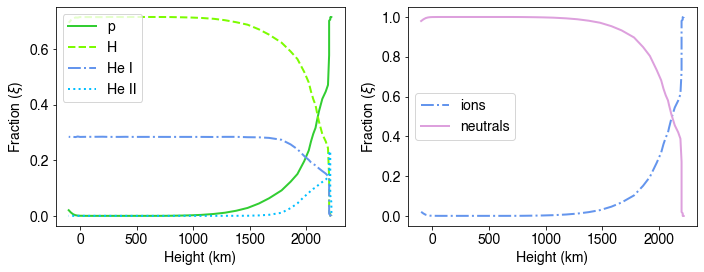

In [89]:
# plot code

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(df_lsa['Depth'], df_lsa['xi_H_i'], label='p', color='limegreen', lw=2)
plt.plot(df_lsa['Depth'], df_lsa['xi_H_n'], label='H', color='lawngreen', linestyle='--', lw=2)
plt.plot(df_lsa['Depth'], df_lsa['xi_He_n'], label='He I', color='cornflowerblue', linestyle='-.', lw=2)
plt.plot(df_lsa['Depth'], df_lsa['xi_He_II'], label='He II', color='deepskyblue', linestyle=':', lw=2)
plt.xlabel('Height (km)')
plt.ylabel(r'Fraction ($\xi$)')
plt.legend(loc='upper left');

plt.subplot(122)
plt.plot(df_lsa['Depth'], df_lsa['xi_i'], label='ions', color='cornflowerblue', linestyle='-.', lw=2)
plt.plot(df_lsa['Depth'], df_lsa['xi_n'], label='neutrals', color='plum', lw=2)
plt.xlabel('Height (km)')
plt.ylabel(r'Fraction ($\xi$)')
plt.legend();

plt.tight_layout()

plt.savefig('ion_neut_frac_all.png')

## Magnetic field geometry

Here we detail the magnetic field geometry of a small-scale magnetic flux tube, likely to be close to those observed in intergranular lanes (magnetic bright points). The specific form of the magnetic field is a semi-empirical formula suggested in Leake et al. (2005).

$$
B_z(z)=B_{ph}\left(\frac{\rho(z)}{\rho_{ph}}\right)^\epsilon,
$$

where subscript $ph$ corresponds to photospheric values, and $\epsilon$ is a free parameter that controls the expansion of the magnetic field.

In the following we also calculate the Alfvén speed:
$$
v_A = \frac{B}{\sqrt{\mu_0\rho}}
$$
and sound speed:
$$
c_s = \sqrt{\frac{R}{\bar{\mu}}T},
$$
where $R$ is the gas constant and $\bar{\mu}$ is the mean atomic weight.

Following Soler et al (2015), we can define 
$$
\bar{\mu} = \left(2\xi_p+\xi_H+\frac{1}{4}\xi_{HeI}+\frac{1}{2}\xi_{HeII} \right)^{-1}
$$
for the lower solar atmosphere, and set $\bar{\mu}=0.6$ in the corona.

<Figure size 1224x360 with 0 Axes>

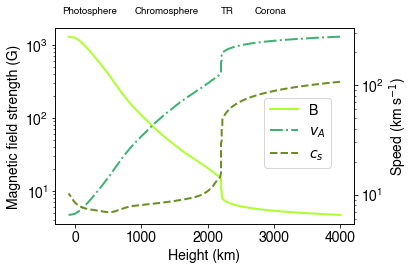

In [90]:
def create_mag_field(B_ph, rho, epsilon):
    return B_ph * (rho / rho[-1])**epsilon

rho = df_lsa['rho'].values
b_z = create_mag_field(1300, rho, 0.3)
df_lsa['Magnetic Field'] = b_z

rho = df['rho'].values
b_z = create_mag_field(1300, rho, 0.3)
df['Magnetic Field'] = b_z

va = (b_z*u.Gauss/np.sqrt(c.mu0*df['rho'].values*u.kg*u.m**-3)).decompose()
df['Alfven Speed'] = va.to(u.km/u.s)

R = 8.3e3*u.Joule/u.Kelvin/u.kg # gas constant

df_lsa['mu_bar'] = (2*df_lsa['xi_H_i']+df_lsa['xi_H_n']+ \
          0.25*df_lsa['xi_He_n']+0.5*df_lsa['xi_He_II'])**-1

mu = np.concatenate( (np.ones(depth_cor.shape[0])*(0.6), 
                 df_lsa['mu_bar'].values))
                    
cs = np.sqrt( (5/3)*R/mu*df['Temp.'].values*u.Kelvin).decompose()
df['Sound Speed'] = cs.to(u.km/u.s)

plt.figure(figsize=(17,5))
fig, ax1 =plt.subplots()

ax1.plot(df['Depth'], b_z, label='B', color='greenyellow', lw=2)
ax1.set_yscale('log')
ax1.set_xlabel("Height (km)")
ax1.set_ylabel("Magnetic field strength (G)")

ax2 = ax1.twinx()
ax2.plot(df['Depth'], df['Alfven Speed'],'-.', label=r'$v_A$',color='mediumseagreen', lw=2)
ax2.plot(df['Depth'], df['Sound Speed'],'--', label=r'$c_s$',color='olivedrab', lw=2)
ax2.set_ylabel(r'Speed (km s$^{-1}$)')
ax2.set_yscale('log')

ax2.text(-200, 450, 'Photosphere', fontsize='x-small')
ax2.text(900, 450, 'Chromosphere', fontsize='x-small')
ax2.text(2200, 450, 'TR', fontsize='x-small')
ax2.text(2700, 450, 'Corona', fontsize='x-small')

fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(0.8,0.65))
    
plt.savefig('B_va_atmosphere.png')

## Collision Frequencies

Of interest in many applications are the coefficients of friction, and/or the collision frequencies of the particles and different species. These equations can be found in many places, but I found the following references helpful ([Zaqarashvili et al. 2013](https://ui.adsabs.harvard.edu/abs/2011A%26A...529A..82Z/abstract); [Soler et al. 2015](https://ui.adsabs.harvard.edu/abs/2015A%26A...573A..79S/abstract); [Soler et al. 2017](https://ui.adsabs.harvard.edu/abs/2017ApJ...840...20S/abstract); [Soler et al 2019](https://ui.adsabs.harvard.edu/abs/2019ApJ...871....3S/abstract))

We will be interested in the collisions between charged particles, and also neutrals and charged particles. Here we define a few equations of interest.

Ion-neutral coefficient of friction (Braginskii 1965 ):
$$
\alpha_{\beta\beta'} = n_\beta n_{\beta'}m_{\beta\beta'}\sigma_{\beta\beta'}\frac{4}{3}\sqrt{\frac{8 k_B T}{\pi m_{\beta\beta'}}}
$$

with collision frequency
$$
\nu_{\beta\beta'}= \frac{\alpha_{\beta\beta'}}{m_\beta n_\beta + m_{\beta'}n_{\beta'}}
$$

Where 
$$
m_{\beta\beta'} = \frac{m_\beta m_{\beta'}}{m_\beta + m_{\beta'} }
$$
is the reduced mass and $\sigma_{\beta\beta'}$ are the collisional cross sections. 



The collisional cross-sections can be calculated from ... We use the following values from (Lewkow et al. 2012; [Vranjes & Krstic 2013](https://ui.adsabs.harvard.edu/abs/2013A%26A...554A..22V/abstract)).


**Ion-neutral cross sections**:
- $\sigma_{iH} \approx 10^{-18}$~m^2, 
- $\sigma_{iHeI} \approx 3\times 10^{-19}$ m^2,
- $\sigma_{HHeI} \approx 1.5\times 10^{-19}$ m^2 

**Electron-neutral**:
- $\sigma_{eH}= 3\times10^{-19}$~m^2
- $\sigma_{eHe}= 6\times10^{-20}$~m^2


The friction coefficient for collisions between two charged species is (e.g., Spitzer 1962; Braginskii 1965)
$$
\alpha_{qq'}=\frac{n_q n_{q'}e^4 \Lambda_{qq'}}{6\pi\sqrt{2\pi}\epsilon_0^2m_{qq'}}\left(\frac{m_{qq'}}{k_BT} \right)^{3/2},
$$
where $q$ = e, p, or He II and $q'=$ e, p, or He II,

The Coulomb logarithm Λ is given by (e.g., Spitzer 1962; Vranjes & Krstic 2013)
$$
\Lambda_{qq'}=\ln\left( \frac{24\pi(\epsilon_0k_BT)^{3/2}}{e^3\sqrt{n_q+n_{q'}}} \right)
$$

Units of $\alpha_{qq'}$ are kg/s/m$^3$.

And the total friction coefficient of species $\beta$ with
the other species is
$$
\alpha_{\beta}=\sum_{\beta'\neq\beta}\alpha_{\beta\beta'}
$$



In [91]:
# functions for calculation of coefficients of friction

def calc_in_coeff_fric(n_i, n_n, m_in, sigma_in,T):
    """
    Calculate coefficient of friction for charged and neutrals (Eq. 8).
    
    n_i - ion number density
    n_n - neutral number density
    m_in - reduced mass
    sigma_in - cross section
    T - temperature 
    
    output units should be kg/s/m^3
    """
    return n_i*n_n*m_in*sigma_in*4/3*np.sqrt( (8*c.k_B*T)/(np.pi*m_in) )

def coloumb_logarithm(n_1, n_2, T):
    """
    Calculate couloumb logarithm (Eq. 12).
    
    n_1 - charged particle number density
    n_2 - charged particle number density
    T - temperature 
    """
    numer = 24*np.pi*(c.eps0*c.k_B*T)**(3/2)
    denom = c.e.si**3*np.sqrt(n_1+n_2)
    return np.log(numer/denom)

def calc_qq_coeff_fric(n_1, n_2, m_12, T):
    """
    Calculate coefficient of friction for charged particles (Eq. 11).
    
    n_1 - charged particle number density
    n_2 - charged particle number density
    m_12 - reduced mass
    T - temperature 
    
    output units should be kg/s/m^3
    """
    coloumb_log = coloumb_logarithm(n_1, n_2, T)
    numer = n_1*n_2*c.e.si**4*coloumb_log
    denom = 6*np.pi*np.sqrt(2*np.pi)*c.eps0**2*m_12
    
    
    return numer/denom*( m_12/c.k_B/T )**(3/2)


Let us now calculate this for the electron collisions. We do this in two ways, one including only charged particles and the other including neutrals.

In [92]:
# electron - charged
q_prime = ['p', 'He II', 'He III']
q_prime_lab = ['Proton', 'He II', 'He III']
label = ['alpha_ep', 'alpha_eHeII', 'alpha_eHeIII']

n_1 = df_lsa['Electron'].values * u.cm**-3
Temp = df_lsa['Temp.'].values * u.K

for qp, qp_lab, lab in zip(q_prime, q_prime_lab, label):
    red_mass = reduced_mass('e',qp)
    n_2 = df_lsa[qp_lab].values * u.cm**-3 # number density
    a = calc_qq_coeff_fric(n_1, n_2, red_mass, Temp )
    df_lsa[lab] = a.decompose().value

# electron - neutrals
red_mass = reduced_mass('e','H')
sigma_eH = 3 * 10**-19 * u.m**2
n_2 = (df_lsa['H(1)']+df_lsa['H(2)']).values*u.cm**-3 # neutral hydrogen number density
a = calc_in_coeff_fric(n_1, n_2, red_mass, sigma_eH, Temp )
df_lsa['alpha_e_H'] = a.decompose().value
       
red_mass = reduced_mass('e','He')
sigma_eHe = 6 * 10**-20 * u.m**2
n_2 = (df_lsa['He(1)']+df_lsa['He(2)']).values * u.cm**-3 # neutral helium number density
a = calc_in_coeff_fric(n_1, n_2, red_mass, sigma_eHe, Temp )
df_lsa['alpha_e_He'] = a.decompose().value 


# charged particles only
df_lsa['alpha_e_q'] = df_lsa['alpha_ep']+df_lsa['alpha_eHeII']+df_lsa['alpha_eHeIII']

# neutrals + charged particles only
df_lsa['alpha_e'] = df_lsa['alpha_e_q']+df_lsa['alpha_e_H']+df_lsa['alpha_e_He']

It can be seen in the following plot that failure to include the collisions with neutrals in the lower solar solar atmosphere under-estimates the coefficient of friction for electron collisions. Collisions with neutral hydrogen and helium independently can be greater than collisions with the protons, between 100-500 km.

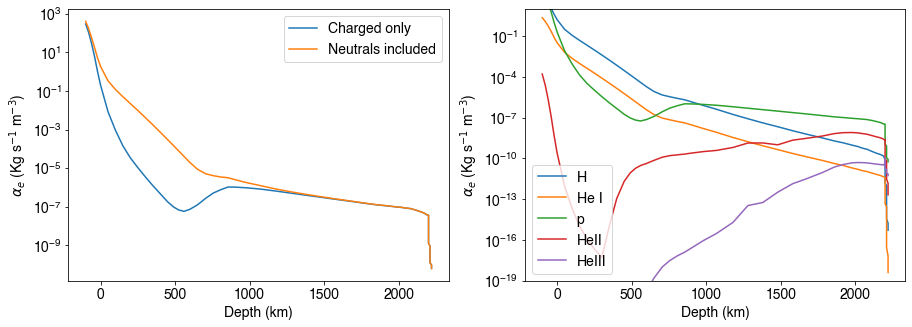

In [93]:
# plot code
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(df_lsa['Depth'], df_lsa['alpha_e_q'], label='Charged only')
plt.plot(df_lsa['Depth'], df_lsa['alpha_e'], label='Neutrals included')
plt.yscale('log')
plt.ylabel(r'$\alpha_e$ (Kg s$^{-1}$ m$^{-3}$)')
plt.xlabel('Depth (km)')
plt.legend()

plt.subplot(122)
label =  ['alpha_e_H','alpha_e_He','alpha_ep', 'alpha_eHeII', 'alpha_eHeIII']
leg_lab =  ['H','He I','p', 'HeII', 'HeIII']

for l, ll in zip(label, leg_lab):
    plt.plot(df_lsa['Depth'], df_lsa[l], label=ll)

plt.yscale('log')
plt.ylabel(r'$\alpha_e$ (Kg s$^{-1}$ m$^{-3}$)')
plt.ylim(1e-19,10)
plt.xlabel('Depth (km)')
plt.legend()

Eqs. (142-145)

Ohmic diffusion
$$
\eta = \frac{α_e}{(en_e)^2\mu}
$$

Hall diffusion
$$
\eta_H = \frac{|B|}{en_e\mu}
$$

Ambipolar (Pederson/Cowling)
$$
\eta_A = \eta_C = \frac{B^2}{\mu_0}\frac{\alpha_{He}\xi_H^2+\alpha_{H}\xi_{He}^2+\alpha_{HeH}(\xi_H+\xi_{He})^2}
{(\alpha_{H}\alpha_{He}+\alpha_{H}\alpha_{HeH}+\alpha_{He}\alpha_{HeH})}
$$


Biermann Battery
$$
\eta_p = \frac{|B|}{en_e\mu}
$$

Ohmic diffusion

In [94]:
# eta_q - charged particles only
alpha_e_q = df_lsa['alpha_e_q'].values * u.kg * u.m**-3 / u.s
n_e = df_lsa['Electron'].values*u.cm**-3

df_lsa['eta_q'] = (alpha_e_q / (c.e.si * n_e)**2 / c.mu0).decompose()


# eta - charged _ neutrals particles
alpha_e = df_lsa['alpha_e'].values * u.kg * u.m**-3 / u.s

df_lsa['eta'] = (alpha_e / (c.e.si * n_e)**2 / c.mu0).decompose()

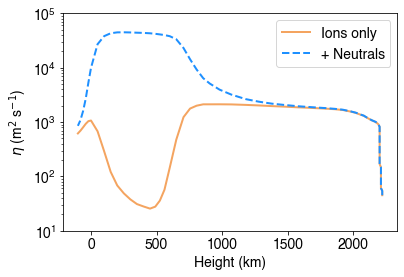

In [96]:
plt.plot(df_lsa['Depth'], df_lsa['eta_q'], lw=2, label='Ions only', color='sandybrown')
plt.plot(df_lsa['Depth'], df_lsa['eta'], '--', lw=2, label='+ Neutrals', color='dodgerblue')
plt.yscale('log')
plt.ylim(10,1e5)
plt.xlabel('Height (km)')
plt.ylabel(r'$\eta$ (m$^{2}$ s$^{-1}$)')
plt.legend()

plt.savefig('eta_comp.png')

Ambipolar diffusion

In [97]:
# proton-neutral hydrogen
red_mass = reduced_mass('p','H')
sigma_iH = 10**-18*u.m**2
sigma_iHe = 3*10**-19*u.m**2
sigma_HHeI = 1.5*10**-19*u.m**2
sigma_gen = 8.7974**-17*u.cm**2 # for direct, elastic collisions from Braginskii

n_i = df_lsa['Proton'].values*u.cm**-3
n_n = (df_lsa['H(1)']+df_lsa['H(2)']).values*u.cm**-3
a = calc_in_coeff_fric(n_i, n_n, red_mass, sigma_iH, df_lsa['Temp.'].values*u.K )
df_lsa['alpha_pH'] = a.decompose().value

# proton-neutral helium
red_mass = reduced_mass('p','He')
n_n = (df_lsa['He(1)']+df_lsa['He(2)']).values*u.cm**-3
a = calc_in_coeff_fric(n_i, n_n, red_mass, sigma_iHe, df_lsa['Temp.'].values*u.K )
df_lsa['alpha_pHe'] = a.decompose().value

# Helium II - neutral hydrogen
red_mass = reduced_mass('He II','H I')

n_i = df_lsa['He II'].values*u.cm**-3
n_n = (df_lsa['H(1)']+df_lsa['H(2)']).values*u.cm**-3
a = calc_in_coeff_fric(n_i, n_n, red_mass, sigma_gen, df_lsa['Temp.'].values*u.K )
df_lsa['alpha_HeIIH'] = a.decompose().value

# Helium II -neutral helium
red_mass = reduced_mass('He II','He I')
n_n = (df_lsa['He(1)']+df_lsa['He(2)']).values*u.cm**-3
a = calc_in_coeff_fric(n_i, n_n, red_mass, sigma_gen, df_lsa['Temp.'].values*u.K )
df_lsa['alpha_HeIIHe'] = a.decompose().value


df_lsa['alpha_H'] = df_lsa['alpha_pH'] + df_lsa['alpha_HeIIH']
df_lsa['alpha_He'] = df_lsa['alpha_pHe'] + df_lsa['alpha_HeIIHe']

Here we ignore the friction of neutral hydrogen+helium fluid with
regards to ions $\alpha_{HeH}$.

In [98]:
eta_A_nB = (df_lsa['alpha_He']*df_lsa['xi_H_n']**2+\
            df_lsa['alpha_H']*df_lsa['xi_He_n']**2)/df_lsa['alpha_H']/df_lsa['alpha_He']

df_lsa['eta_A'] = ((df_lsa['Magnetic Field'].values*u.Gauss)**2/c.mu0 * eta_A_nB.values /(u.kg * u.m**-3 / u.s)).decompose()

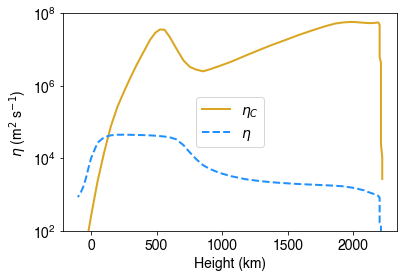

In [100]:
plt.plot(df_lsa['Depth'], df_lsa['eta_A'], lw=2, label=r'$\eta_C$', color='goldenrod')
plt.plot(df_lsa['Depth'],df_lsa['eta'], '--', lw=2, label=r'$\eta$', color='dodgerblue')
plt.yscale('log')
plt.ylim(100,10**8)
plt.xlabel('Height (km)')
plt.ylabel(r'$\eta$ (m$^{2}$ s$^{-1}$)')
plt.legend()

plt.savefig('cowling_vs_ohmic.png')

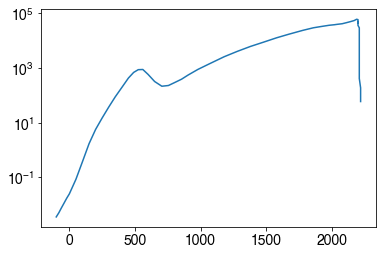

In [76]:
plt.plot(df_lsa['Depth'], df_lsa['eta_A']/df_lsa['eta'])
plt.yscale('log')

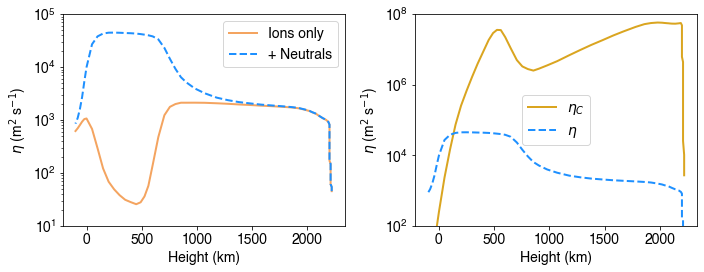

In [101]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(df_lsa['Depth'], df_lsa['eta_q'], lw=2, label='Ions only', color='sandybrown')
plt.plot(df_lsa['Depth'], df_lsa['eta'], '--', lw=2, label='+ Neutrals', color='dodgerblue')
plt.yscale('log')
plt.ylim(10,1e5)
plt.xlabel('Height (km)')
plt.ylabel(r'$\eta$ (m$^{2}$ s$^{-1}$)')
plt.legend()

plt.subplot(122)
plt.plot(df_lsa['Depth'], df_lsa['eta_A'], lw=2, label=r'$\eta_C$', color='goldenrod')
plt.plot(df_lsa['Depth'],df_lsa['eta'], '--', lw=2, label=r'$\eta$', color='dodgerblue')
plt.yscale('log')
plt.ylim(100,10**8)
plt.xlabel('Height (km)')
plt.ylabel(r'$\eta$ (m$^{2}$ s$^{-1}$)')
plt.legend()
plt.tight_layout()
plt.savefig('eta_comb.png')

Non-linearity

Here is rough estimate of wave non-linearity with height.

Assume that wave amplitude obeys WKB approximation, i.e. $\delta v\propto \rho^{-1/4}$. Then calculate ratio of 

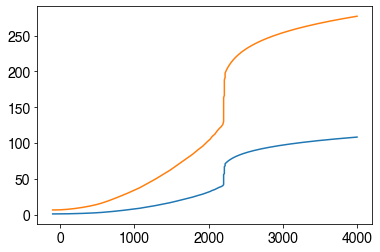

In [103]:
#WKB
def v_with_height(v_init):
    r_frac = np.sqrt(df['Magnetic Field'].values[-1]/df['Magnetic Field'])
    va_frac = np.sqrt(df['Alfven Speed']/df['Alfven Speed'].values[-1])
    return v_init*va_frac*r_frac

v_init = 1*u.km/u.s

v_height = v_with_height(v_init)
plt.plot(df['Depth'], v_height)
plt.plot(df['Depth'], df['Alfven Speed'])

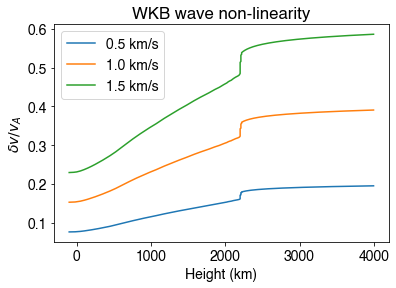

In [104]:
v_init = [0.5, 1., 1.5 ]

for vi in v_init:
    v_height = v_with_height(vi)
    nl_meas = v_height/df['Alfven Speed']

    plt.plot(df['Depth'], nl_meas, label='{:1.2} km/s'.format(vi))

plt.xlabel('Height (km)')
plt.ylabel(r'$\delta v / v_A$')

plt.title('WKB wave non-linearity')

plt.legend()
plt.savefig('non_linearity.png')

In [105]:
1./(df['Magnetic Field'].values[-1]/df['Magnetic Field'])

0      0.003617
1      0.003619
2      0.003621
3      0.003622
4      0.003624
         ...   
421    0.976013
422    0.985118
423    0.991316
424    0.993839
425    1.000000
Name: Magnetic Field, Length: 426, dtype: float64